In [17]:
#include Google Drive to work with files
from google.colab import drive
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")
import os
from tqdm import tqdm

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
MAIN_FOLDER = "/content/drive/My Drive/HackLab/3_Lenta/data"
data_path = f'{MAIN_FOLDER}/feat_lab.csv'

### Load data

In [3]:
data = pd.read_csv(data_path)

In [4]:
data.head()

,client_id,fier_feat0,fier_feat1,fier_feat2,fier_feat3,fier_feat4,fier_feat5,fier_feat6,fier_feat7,fier_feat8,fier_feat9,fier_feat10,fier_feat11,fier_feat12,fier_feat13,fier_feat14,fier_feat15,fier_feat16,fier_feat17,fier_feat18,fier_feat19,fier_feat20,fier_feat21,fier_feat22,fier_feat23,fier_feat24,fier_feat25,fier_feat26,fier_feat27,fier_feat28,fier_feat29,fier_feat30,fier_feat31,fier_feat32,fier_feat33,fier_feat34,fier_feat35,fier_feat36,fier_feat37,fier_feat38,...,fier_feat2183,fier_feat2184,fier_feat2185,fier_feat2186,fier_feat2187,fier_feat2188,fier_feat2189,fier_feat2190,fier_feat2191,fier_feat2192,fier_feat2193,fier_feat2194,fier_feat2195,fier_feat2196,fier_feat2197,fier_feat2198,fier_feat2199,fier_feat2200,fier_feat2201,fier_feat2202,fier_feat2203,fier_feat2204,fier_feat2205,fier_feat2206,fier_feat2207,fier_feat2208,fier_feat2209,fier_feat2210,fier_feat2211,fier_feat2212,fier_feat2213,fier_feat2214,fier_feat2215,first,last,max_count,avg_count,max_sum,avg_sum,label
0,5afb724ed4347c362a0812ab6d9fe7e5,12.798262,0.901639,1.319672,0.672131,0.139344,1.491803,1.229508,1.022197,0.426230,0.573770,0.885246,0.553230,0.853254,0.000000,0.131148,0.246426,0.302213,0.008197,0.418033,0.397844,0.491803,0.081967,0.303279,0.040984,0.040984,0.090164,0.07377,0.131148,0.00,0.000,0.000000,0.073770,0.032787,0.000000,0.418033,0.02459,0.188525,0.377049,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2016-10-05,2017-09-29,31.078,13.699902,9639.0,1375.360656,0
1,94ddced06e5c60f3e9e6cd15fd1ff629,7.122375,5.625000,0.250000,0.000000,0.000000,1.000000,0.875000,1.980250,0.000000,0.250000,0.000000,0.000000,0.000000,0.125000,0.000000,0.159000,1.875000,0.125000,1.750000,0.086250,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.25,0.375,0.000000,0.125000,0.000000,0.000000,0.000000,0.00000,2.375000,0.000000,0.375000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2016-10-14,2017-03-12,24.137,12.747375,2523.0,1109.500000,1
2,ad7a8ac337c13377529856e3c28c8c69,7.064125,2.500000,0.250000,0.125000,0.000000,0.000000,0.500000,0.091250,0.500000,0.000000,0.750000,0.385250,0.247375,0.000000,0.875000,1.785875,1.250000,0.125000,1.000000,0.109750,0.125000,0.000000,0.000000,0.125000,0.000000,0.125000,0.00000,0.500000,0.00,0.125,0.000000,0.375000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2016-10-28,2017-06-28,14.187,9.564125,1577.0,1208.375000,1
3,0a09e7a042aa04f4bd6083996399ba92,53.435983,20.900000,1.283333,0.133333,0.100000,1.116667,0.833333,4.799683,1.833333,13.783333,4.550000,0.685700,0.630400,0.133333,5.450000,0.930383,1.781150,0.150000,6.283333,1.438083,0.750000,3.700000,1.183333,0.766667,0.566667,0.450000,0.00000,1.233333,0.20,0.650,0.033333,1.000000,0.050000,1.650000,0.739600,0.45000,2.866667,0.316667,0.133333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016667,0.0,0.0,0.0,0.0,2016-10-06,2017-10-04,178.878,74.335983,20631.0,8924.900000,0
4,ddc9ad154489e3960f4b19ca268c6daf,6.015956,3.055556,0.700000,0.000000,0.233333,0.222222,0.155556,1.274411,0.711111,0.022222,0.488889,0.134833,0.145822,0.211111,0.366667,0.052022,0.311111,0.033333,1.200000,0.163844,0.011111,0.288889,0.333333,0.000000,0.000000,0.011111,0.00000,0.055556,0.00,0.000,0.000000,0.255556,0.144444,0.044444,0.033333,0.00000,0.000000,0.022222,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2016-10-07,2017-05-13,58.000,9.071511,7139.0,707.443778,1


In [6]:
X = data.drop(columns=['client_id', 'first', 'last', 'label']).values
y = data['label'].values

In [7]:
(X_train, X_test,
 y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=175)

The dataset is imbalanced

In [8]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1]), array([616, 240])), (array([0, 1]), array([153,  62])))

Oversample using SMOTE

In [9]:
oversample = SMOTE(random_state=175, n_jobs=-1, sampling_strategy=0.8)
X_ov, y_ov = oversample.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [10]:
np.unique(y_ov, return_counts=True)

(array([0, 1]), array([616, 492]))

### Train the XGBoost model

In [11]:
import graphviz

In [12]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, n_jobs=-1, eval_metric='auc')
xgb_model.fit(X_ov, y_ov)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [13]:
y_pred = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))

[[125  28]
 [ 26  36]]


In [14]:
roc_auc_score(y_test, y_pred)

0.698819312671305

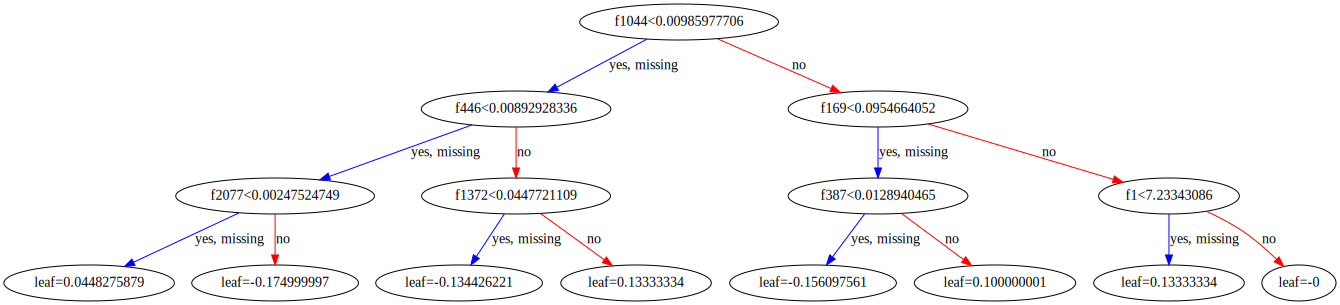

In [15]:
xgb.to_graphviz(xgb_model)

### Train the final classifier

In [18]:
estimators = [
              ('xgboost', xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric='auc')),
              ('knn', KNeighborsClassifier(n_jobs=-1))
              ]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(), n_jobs=-1
)
clf.fit(X_ov, y_ov)

StackingClassifier(cv=None,
                   estimators=[('xgboost',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1,
                                              eval_metric='auc', gamma=0,
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=3,
                                              min_child_weight=1, missing=None,
                                              n_estimators=100, n_jobs=1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=42, reg_alph...
                                                     n_jobs=-1, n_neig

In [19]:
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))

[[132  21]
 [ 28  34]]


In [20]:
roc_auc_score(y_test, y_pred)

0.7055660974067046